# Chapter 20: Double Deep Q-Learning






New Skills in This Chapter:

• Creating a double deep Q-learning model

• Obtaining the weights from a deep neural network

• Assigning weights to a deep neural network

• Training a double Q-network for Breakout

• Playing Breakout with the trained double Q-network

***
*These overestimations result from a positive bias that is introduced because Q-learning uses the maximum action value as an approximation for the maximum expected action value.*<br>
***
Double Q-learing<br>
--Hado van Hasselt, 2010, NeurIPS Proceedings


***

In [1]:
import os

os.makedirs("files/ch20", exist_ok=True)

***
$\mathbf{\text{Install OpenAI Baselines}}$<br>
***
We'll use the OpenAI Baselines library to train several Atari games from this chapter onwards. The Baselines library provides a Atari Gym wrapper for various games to make the training of RL models easier. For more details, go to their GitHub repository https://github.com/openai/baselines.

To install OpenAI Baselines, make sure that you have installed atari_py and ROMS on your computer. If not, refer to Chapter 18 on how to install. 

Also, make sure you are using version 0.15.7 of the OpenAI Gym environment. In case you accidentally installed a different version, run the following lines of code to correct it.

`pip uninstall gym`

`pip install gym==0.15.7`
 

Here are the steps to install OpenAI Baselines:
* Step 1: Make sure you have Git installed on your computer; if not, see instructions via the link below https://git-scm.com/book/en/v2/Getting-Started-Installing-Git. 
* Step 2: Open the Anaconda prompt (Windows) or a terminal (MAC or Linux) and activate the virtual environment *MLA*. Clone the OpenAI Baselines repository by running the following line of command:

`git clone https://github.com/openai/baselines.git`

* Step 3: Go into the baselines directory by running the following line of command:

`cd baselines`

* Step 4: Install the baselines package in the virtual environment by running the following command:

`pip install -e .`

Make sure you don't miss the dot at the end of the above command. 

After that, restart your Jupyter Notebook for the package to take effect.
***

# 20.1. Get Started with OpenAI Baselines

## 20.1.1. The Breakout Game with OpenAI Baselines

In [2]:
from baselines.common.atari_wrappers import make_atari
from baselines.common.atari_wrappers import wrap_deepmind

# Use the Baseline Atari environment
env = make_atari("BreakoutNoFrameskip-v4")
# Process and stack the frames
env = wrap_deepmind(env, frame_stack=True, scale=True)

obs = env.reset()
while True:
    # randomly pick actions
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    print(action, reward, done, info)
    # Render the env
    env.render()
    if done:
        break

C:\Users\hlliu2\Anaconda3\envs\MLA\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


0 0.0 False {'ale.lives': 5}
1 0.0 False {'ale.lives': 5}
2 0.0 False {'ale.lives': 5}
3 0.0 False {'ale.lives': 5}
1 0.0 False {'ale.lives': 5}
2 0.0 False {'ale.lives': 5}
1 0.0 False {'ale.lives': 5}
0 0.0 False {'ale.lives': 5}
1 0.0 False {'ale.lives': 5}
0 0.0 False {'ale.lives': 5}
3 0.0 False {'ale.lives': 5}
2 0.0 False {'ale.lives': 5}
0 0.0 False {'ale.lives': 5}
3 0.0 False {'ale.lives': 5}
1 0.0 False {'ale.lives': 5}
1 0.0 False {'ale.lives': 5}
3 0.0 False {'ale.lives': 5}
1 0.0 False {'ale.lives': 5}
0 0.0 False {'ale.lives': 5}
2 0.0 False {'ale.lives': 5}
3 0.0 False {'ale.lives': 5}
1 0.0 False {'ale.lives': 5}
1 0.0 True {'ale.lives': 4}


In [3]:
env.close()

## 20.1.2. Preprocessed Frames from Baselines

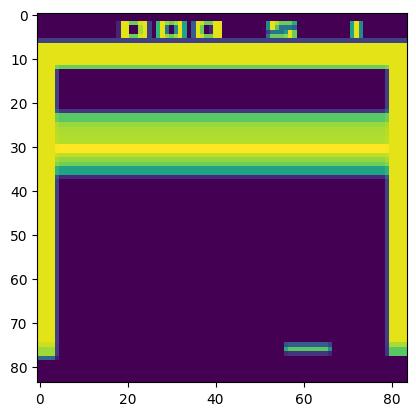

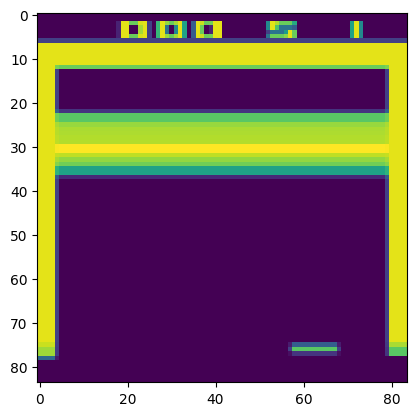

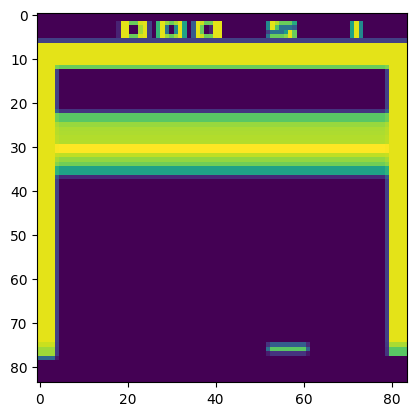

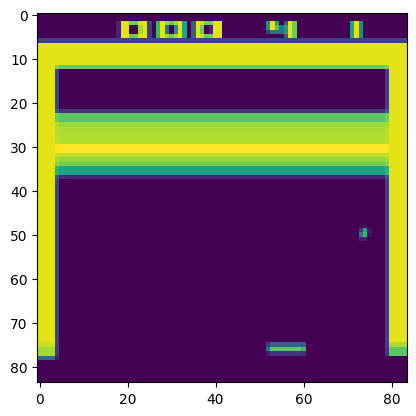

In [4]:
import matplotlib.pyplot as plt
import numpy as np

npobs=np.array(obs)
for i in range(4):
    plt.imshow(npobs[:,:,i])
    plt.show()

## 20.1.3. Subplots of Preprocessed Frames

C:\Users\hlliu2\Anaconda3\envs\MLA\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


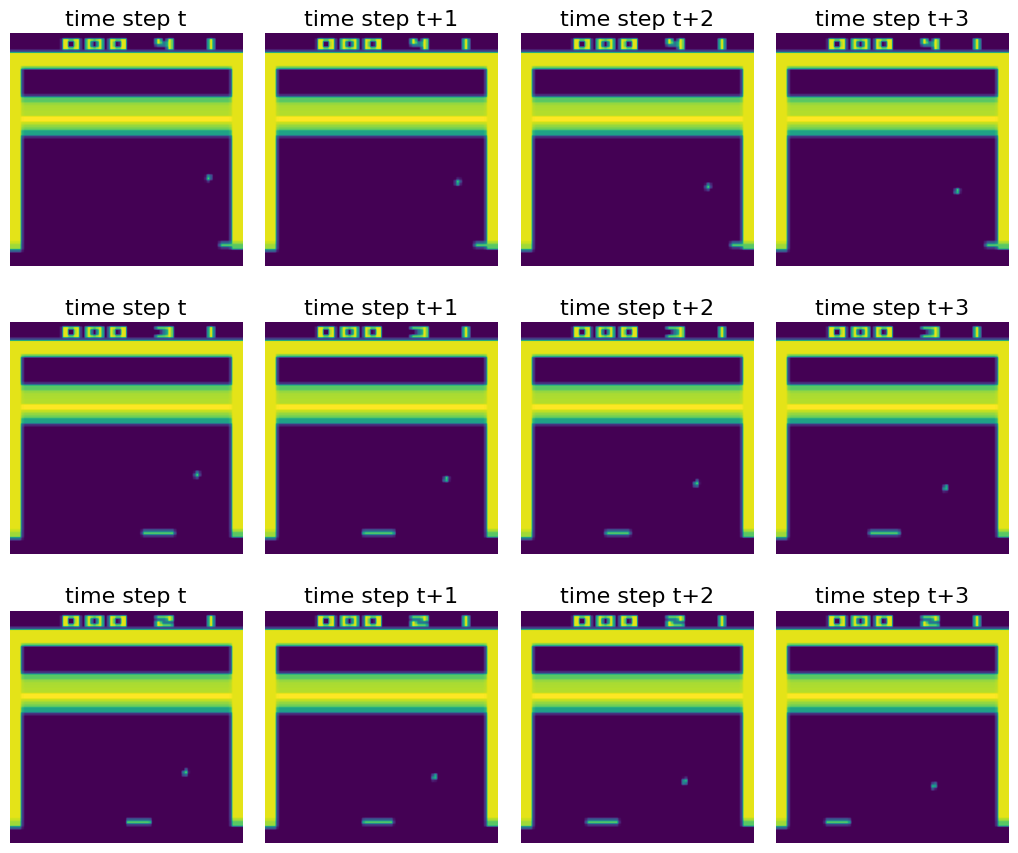

In [5]:
from utils.ch20util import four_frames

four_frames()

# 20.2. Train the Double Deep Q Agent

## 20.2.1. Create A Double Deep Q-Network

In [6]:
import tensorflow as tf
from tensorflow import keras

# Input and output shape
input_shape = (84, 84, 4,)
num_actions = 4
def create_model():
    model=keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=32,kernel_size=8,
         strides=(4,4), activation="relu",
         input_shape=input_shape))
    model.add(keras.layers.Conv2D(filters=64,kernel_size=4,
         strides=(2,2), activation="relu"))
    model.add(keras.layers.Conv2D(filters=64,kernel_size=3,
         strides=(1,1), activation="relu"))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512, activation="relu"))
    model.add(keras.layers.Dense(num_actions))
    return model

In [7]:
# Network for training
dnn=create_model()
# Network for predicting (target network)
target_dnn=create_model()

In [8]:
lr=0.00025
optimizer=keras.optimizers.Adam(learning_rate=lr,clipnorm=1)
loss_function=keras.losses.Huber()

## 20.2.2. Train the Deep Q Network
  

In [9]:
import random
from collections import deque

# Discount factor for past rewards
gamma = 0.99 
# batch size
batch_size = 32  
# Create a replay buffer 
memory=deque(maxlen=50000)
# Create a running rewards list 
running_rewards=deque(maxlen=100)

In [10]:
# Generate a batch
def gen_batch():
    # select a batch from the buffer memory
    samples = random.sample(memory,batch_size)
    dones = []
    frames = []
    new_frames = []
    rewards = []
    actions = []
    for sample in samples:
        frame, new_frame, action, reward, done = sample
        frames.append(frame)
        new_frames.append(new_frame)
        actions.append(action)  
        dones.append(done)
        rewards.append(reward)
    frames=np.array(frames)
    new_frames=np.array(new_frames)
    dones=tf.convert_to_tensor(dones)
    return dones,frames,new_frames,rewards,actions

In [11]:
# Replay and update model parameters
def update_Q():
    dones,frames,new_frames,rewards,actions=gen_batch()
    # update the Q table
    preds = target_dnn.predict(new_frames, verbose=0)
    Qs = rewards + gamma * tf.reduce_max(preds, axis=1)
    # if done=1  reset Q to  -1; important
    new_Qs = Qs * (1 - dones) - dones
    # update model parameters
    onehot = tf.one_hot(actions, num_actions)
    with tf.GradientTape() as t:
        Q_preds=dnn(frames)
        # Calculate old Qs for the action taken
        old_Qs=tf.reduce_sum(tf.multiply(Q_preds,onehot),axis=1)
        # Calculate loss between new Qs and old Qs
        loss=loss_function(new_Qs, old_Qs)
    # Update using backpropagation
    gs=t.gradient(loss,dnn.trainable_variables)
    optimizer.apply_gradients(zip(gs,dnn.trainable_variables))

In [12]:
# Let the game begin
running_reward = 0
frame_count = 0
# Number of frames to take random actions
epsilon_random_frames = 50000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 10000

In [13]:
def play_episode():
    global frame_count
    # reset state and episode reward before each episode
    state = np.array(env.reset())
    episode_reward = 0    
    # Allow 10,000 steps per episode
    for timestep in range(1, 10001):
        frame_count += 1
        # Calculate current epsilon based on frame count
        epsilon = max(0.1, 1 - frame_count * (1-0.1) /1000000)
        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or \
            epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        # Use exploitation
        else:
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = dnn(state_tensor, training=False)
            action = tf.argmax(action_probs[0]).numpy()
        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)
        episode_reward += reward
        # Change done to 1.0 or 0.0 to prevent error
        if done==True:
            done=1.0
        else:
            done=0.0
        # Save actions and states in replay buffer
        memory.append([state, state_next, action, reward, done])
        # current state becomes the next state in next round
        state = state_next
        # Update Q once batch size is over 32
        if len(memory) > batch_size and \
            frame_count % update_after_actions == 0:
            update_Q()
        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            target_dnn.set_weights(dnn.get_weights())
            # Periodically save the model
            dnn.save("files/ch20/DoubleQ_Breakout.h5")         
        if done:
            running_rewards.append(episode_reward)
            break

In [14]:
episode=0
frame_count=0
while True: 
    episode += 1
    play_episode()
    running_reward = np.mean(np.array(running_rewards))
    if episode%20==0:
        # Log details
        msg="running reward: {:.2f} at episode {} and frame {}"
        print(msg.format(running_reward,episode,frame_count))
    if running_reward>20:
        dnn.save("files/ch20/DoubleQ_Breakout.h5")
        print(f"solved at episode {episode}")
        break

The number of trainable parameters is 1,686,180. The model takes several days to train. But you can use a trained model in the book's GitHub repository.

# 12.3. Test the Trained Breakout Agent

## 12.3.1. Testing One Original Episode

In [15]:
from tensorflow.keras import models 

reload=models.load_model("files/ch20/DoubleQ_Breakout.h5")
for i in range(5):
    state=env.reset()
    for j in range(10000):
        if np.random.rand(1)[0]<0.01:
            action=np.random.choice(4)
        else:
            state_tensor=tf.convert_to_tensor(state)
            state_tensor=tf.expand_dims(state_tensor,0)
            action_Qs=reload(state_tensor,training=False)
            action=tf.argmax(action_Qs[0]).numpy()    
        state, reward, done, info = env.step(action)
        env.render()
        if done:
            break
env.close()

## 12.3.2. Play Multiple Games and Test the Average Score

In [16]:
from utils.ch20util import test_breakout

test_breakout()

the score in episode 1 is 5.0
the score in episode 2 is 26.0
the score in episode 3 is 64.0
the score in episode 4 is 0.0
the score in episode 5 is 0.0
the score in episode 6 is 0.0
the score in episode 7 is 5.0
the score in episode 8 is 4.0
the score in episode 9 is 71.0
the score in episode 10 is 2.0
the score in episode 11 is 1.0
the score in episode 12 is 5.0
the score in episode 13 is 9.0
the score in episode 14 is 3.0
the score in episode 15 is 65.0
the score in episode 16 is 0.0
the score in episode 17 is 3.0
the score in episode 18 is 4.0
the score in episode 19 is 16.0
the score in episode 20 is 2.0
the score in episode 21 is 4.0
the score in episode 22 is 13.0
the score in episode 23 is 78.0
the score in episode 24 is 0.0
the score in episode 25 is 0.0
the score in episode 26 is 0.0
the score in episode 27 is 68.0
the score in episode 28 is 5.0
the score in episode 29 is 1.0
the score in episode 30 is 5.0
the score in episode 31 is 12.0
the score in episode 32 is 48.0
the sco

# 12.4. Animate Successful Episodes

## 12.4.1. Collect Successful Episodes

In [17]:
from utils.ch20util import collect_episode

collect_episode()        

Since each game is different, I’ll use the episode I collected as the example. Download
the file breakout_frames1.zip from the book’s GitHub repository and unzip the file
and place it in /Desktop/mla/files/ch20/ on your computer. After that, run this code
cell:

In [18]:
import matplotlib.pyplot as plt
import pickle

frames=pickle.load(open("files/ch20/breakout_frames1.p","rb"))
for i in range(len(frames)):
    plt.imshow(frames[i])
    plt.axis("off")
    plt.savefig(f"files/ch20/photo{i}")

In [19]:
import imageio

imageio.mimsave("files/ch20/breakout_highlight.gif", 
                frames[100:294], fps=240)

<img src="https://gattonweb.uky.edu/faculty/lium/ml/breakout_highlight.gif" />

## 4.2. A Picture with Subplots

In [20]:
plots=frames[100:294][::8]

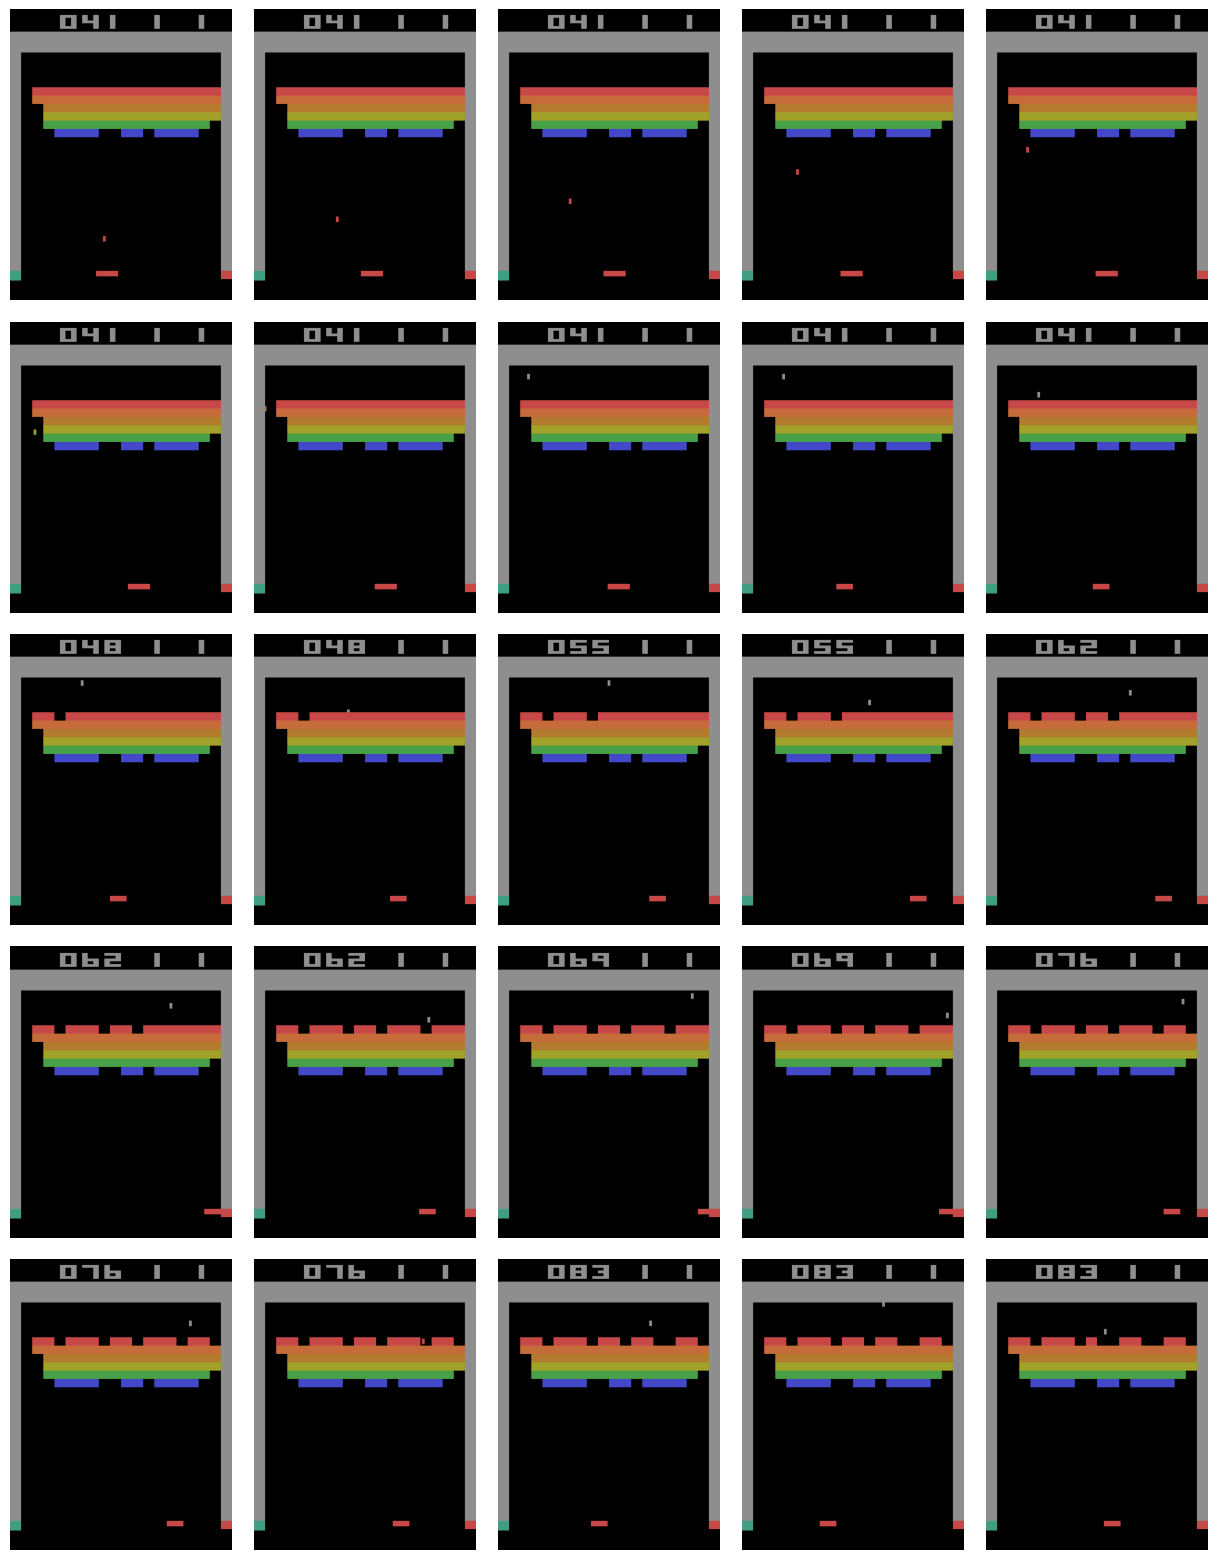

In [21]:
plt.figure(figsize=(12,16),dpi=100)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(plots[i])
    plt.axis('off')
plt.subplots_adjust(bottom=0.001,right=0.999,top=0.999,
left=0.001, hspace=-0.1,wspace=0.1)
plt.savefig("files/ch20/DoubleQ_plots.png")